In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from jupyterthemes import jtplot
jtplot.style(theme='onedork')
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_train = pd.read_csv('data/train_clean.csv', index_col = 0)
df_test = pd.read_csv('data/test_clean.csv', index_col = 0)


# Re-write as functin
features = pd.read_csv('data/features.csv', index_col = 0)
features = features.values.tolist()
flat_list = []
for sublist in features:
    for item in sublist:
        flat_list.append(item)
        features = flat_list

df_train_ml = df_train[features].copy()
df_test_ml  = df_test[features].copy()

target = 'SalePrice_Log'
test_ids = list(df_test.index.values)  

# Checking the Model
This is just a check that I didn't do anything foolish in the transition from the Data Cleaning / Analysis Jupyter Notebook.

In [3]:
#y_train =  df_train[target]
#X_train = df_train_ml

#lm = LinearRegression()
#lm.fit(X_train, y_train)
#lm.score(X_train, y_train)

# Standardization

In [4]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
df_train_ml_sc = sc.fit_transform(df_train_ml)
df_test_ml_sc = sc.transform(df_test_ml)
df_train_ml_sc = pd.DataFrame(df_train_ml_sc)
df_train_ml_sc.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.658506,1.052959,0.880362,0.523937,-0.473766,0.793546,-0.952231,0.313159,0.438861,0.348833,1.40986,0.648281,0.741127,0.539624,-0.129585
1,-0.068293,0.158428,-0.428115,-0.570739,0.504925,0.793546,0.605965,0.313159,0.438861,0.348833,-0.70929,0.648281,-0.770150,-0.380198,0.118848
2,0.658506,0.986698,0.831900,0.334044,-0.319490,0.793546,0.605965,0.313159,0.438861,0.348833,1.40986,0.648281,0.741127,0.671287,0.427653
3,0.658506,-1.862551,-0.718888,-0.570739,-0.714823,-1.025620,0.605965,1.652119,0.438861,0.348833,-0.70929,-0.921808,0.741127,0.551993,0.108680
4,1.385305,0.953567,0.734975,1.384039,0.222888,0.793546,0.605965,1.652119,0.438861,2.010918,1.40986,0.648281,0.741127,1.299759,0.889271


#### Define Variables

In [5]:
X = df_train_ml.copy()
y = df_train[target]

X_sc = df_train_ml_sc.copy()
y_sc = df_train[target]

X_test = df_test_ml.copy()
X_test_sc = df_test_ml_sc.copy()

#X.info()
#X_test.info()
#X_sc.head()
#X_test.head()

# Model Selection

In [6]:
from sklearn.model_selection import GridSearchCV
score_calc = 'neg_mean_squared_error'
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

#### A note on the theory / plan.  (Tighten this up)

The regressor.best_score_ is the average of r2 scores on left-out test folds for the best parameter combination, i.e.:
1.  The average of the 'n_cv' test scores obtained from a train/test sub-split of the original train data. 
2.  This is repeated for all parameter combinations. And the best average score is assigned to the best_score_.
3.  After finding the best parameters, the model is trained on full data.
r2(y_pred = best.predict(X), y_true = y)





In [7]:
n_cv = 5

def cv_best_score(grid):  
    best_score = np.sqrt(-grid.best_score_)
    print(best_score)    
    #print(grid.best_params_)
    #print(grid.best_estimator_)
    return best_score

## Linear Regression
Working on running non-sc and sc in parallel to verify everything works correctly.


In [8]:
lm = LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid_lm = GridSearchCV(lm, parameters, cv = n_cv, verbose = 1 , scoring = score_calc)
grid_lm.fit(X, y)
sc_lm = cv_best_score(grid_lm)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.2s finished


0.1360971424095817


In [9]:
lm_sc = LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid_lm_sc = GridSearchCV(lm_sc, parameters, cv = n_cv, verbose = 1 , scoring = score_calc)
grid_lm_sc.fit(X_sc, y)
sc_lm_sc = cv_best_score(grid_lm_sc)
sc_lm_sc

Fitting 5 folds for each of 8 candidates, totalling 40 fits
0.13609714240958165


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.2s finished


0.13609714240958165

In [10]:
#Note: Right now, the mean imputation isn't needed but I hit a few bumps along the way so it's there as a fail-safe. Will come back to this later.
lm_all = LinearRegression()
lm_all.fit(X, y)
pred_lm_all = lm_all.predict(X_test)
pred_lm_all[pred_lm_all < 0] = pred_lm_all.mean()

In [11]:
submit_lm = pd.DataFrame()
submit_lm['Id'] = test_ids
submit_lm['SalePrice'] = pred_lm_all
submit_lm['SalePrice'] = np.exp(submit_lm['SalePrice'])
submit_lm.to_csv('submit_lm.csv',index=False)

# Ridge

In [12]:
ridge = Ridge()
parameters = {'alpha':[0.001,0.005,0.01,0.1,0.5,1], 'normalize':[True,False], 'tol':[1e-06,5e-06,1e-05,5e-05]}
grid_ridge = GridSearchCV(ridge, parameters, cv = n_cv, verbose = 1, scoring = score_calc)
grid_ridge.fit(X, y)
sc_ridge = cv_best_score(grid_ridge)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.13608446315823144


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:    1.1s finished


In [13]:
ridge_sc = Ridge()
parameters = {'alpha':[0.001,0.005,0.01,0.1,0.5,1], 'normalize':[True,False], 'tol':[1e-06,5e-06,1e-05,5e-05]}
grid_ridge_sc = GridSearchCV(ridge_sc, parameters, cv=n_cv, verbose=1, scoring = score_calc)
grid_ridge_sc.fit(X_sc, y)
sc_ridge_sc = cv_best_score(grid_ridge_sc)
pred_ridge_all = grid_ridge.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 48 candidates, totalling 240 fits
0.13608446315823153


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:    0.9s finished


In [14]:
submit_ridge = pd.DataFrame()
submit_ridge['Id'] = test_ids
submit_ridge['SalePrice'] = pred_ridge_all
submit_ridge['SalePrice'] = np.exp(submit_ridge['SalePrice'])
submit_ridge.to_csv('submit_ridge.csv',index = False)

# Lasso

In [15]:
lasso = Lasso()
parameters = {'alpha':[1e-03,0.01,0.1,0.5,0.8,1], 'normalize':[True,False], 'tol':[1e-06,1e-05,5e-05,1e-04,5e-04,1e-03]}
grid_lasso = GridSearchCV(lasso, parameters, cv = n_cv, verbose = 1, scoring = score_calc)
grid_lasso.fit(X, y)
sc_lasso = cv_best_score(grid_lasso)
pred_lasso_all = grid_lasso.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 72 candidates, totalling 360 fits
0.1363615362328576


[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:    2.0s finished


In [16]:
submit_lasso = pd.DataFrame()
submit_lasso['Id'] = test_ids
submit_lasso['SalePrice'] = pred_lasso_all
submit_lasso['SalePrice'] = np.exp(submit_lasso['SalePrice'])
submit_lasso.to_csv('submit_lasso.csv',index=False)

# EslasticNet

In [17]:
enet = ElasticNet()
parameters = {'alpha' :[0.1,1.0,10], 'max_iter' :[1000000], 'l1_ratio':[0.04,0.05], 
              'fit_intercept' : [False,True], 'normalize':[True,False], 'tol':[1e-02,1e-03,1e-04]}
grid_enet = GridSearchCV(enet, parameters, cv = n_cv, verbose = 1, scoring = score_calc)
grid_enet.fit(X_sc, y_sc)
sc_enet = cv_best_score(grid_enet)
pred_enet = grid_enet.predict(X_test_sc)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 72 candidates, totalling 360 fits
0.13716480990213142


[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:    1.7s finished


In [18]:
submit_enet = pd.DataFrame()
submit_enet['Id'] = test_ids
submit_enet['SalePrice'] = pred_enet
submit_enet['SalePrice'] = np.exp(submit_enet['SalePrice'])
submit_enet.to_csv('submit_enet.csv',index = False)

# SGD

In [19]:
sgd = SGDRegressor()
parameters = {'max_iter' :[10000], 
              'alpha':[1e-05], 
              'epsilon':[1e-02], 
              'fit_intercept' : [True]}
grid_sgd = GridSearchCV(sgd, parameters, cv = n_cv, verbose = 1, scoring = score_calc)
grid_sgd.fit(X_sc, y_sc)
sc_sgd = cv_best_score(grid_sgd)
pred_sgd = grid_sgd.predict(X_test_sc)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.13657655634088228


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


In [20]:
submit_sgd = pd.DataFrame()
submit_sgd['Id'] = test_ids
submit_sgd['SalePrice'] = pred_sgd
submit_sgd['SalePrice'] = np.exp(submit_sgd['SalePrice'])
submit_sgd.to_csv('submit_sgd.csv',index = False)

# DecisionTree

In [21]:
param_grid = {'max_depth' : [7,8,9,10] , 
              'max_features' : [11,12,13,14], 
              'max_leaf_nodes' : [None, 12,15,18,20],
              'min_samples_split' : [20,25,30],
              'presort': [False,True] , 'random_state': [5]}       
grid_dtree = GridSearchCV(DecisionTreeRegressor(), param_grid, cv = n_cv, refit = True, verbose = 1, scoring = score_calc)
grid_dtree.fit(X, y)
sc_dtree = cv_best_score(grid_dtree)
pred_dtree = grid_dtree.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits
0.18255842938057673


[Parallel(n_jobs=1)]: Done 2400 out of 2400 | elapsed:   16.5s finished


In [22]:
submit_dtree = pd.DataFrame()
submit_dtree['Id'] = test_ids
submit_dtree['SalePrice'] = pred_dtree
submit_dtree['SalePrice'] = np.exp(submit_dtree['SalePrice'])
submit_dtree.to_csv('submit_dtree.csv',index = False)

# RandomForest

In [23]:
param_grid = {'min_samples_split' : [3,4,6,10], 
              'n_estimators' : [70,100], 
              'random_state': [5]}
grid_rf = GridSearchCV(RandomForestRegressor(), param_grid, cv = n_cv, refit = True, verbose=1, scoring = score_calc)
grid_rf.fit(X, y)
sc_rf = cv_best_score(grid_rf)
pred_rf = grid_rf.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   14.6s finished


0.14621609629650129


In [24]:
submit_rf = pd.DataFrame()
submit_rf['Id'] = test_ids
submit_rf['SalePrice'] = pred_rf
submit_rf['SalePrice'] = np.exp(submit_rf['SalePrice'])
submit_rf.to_csv('submit_rf.csv',index = False)

# KNN


In [25]:
param_grid = {'n_neighbors' : [3,4,5,6,7,10,15] ,    
              'weights' : ['uniform','distance'] ,
              'algorithm' : ['ball_tree', 'kd_tree', 'brute']}
grid_knn = GridSearchCV(KNeighborsRegressor(), param_grid, cv = n_cv, refit = True, verbose = 1, scoring = score_calc)
grid_knn.fit(X_sc, y_sc)
sc_knn = cv_best_score(grid_knn)
pred_knn = grid_knn.predict(X_test_sc)

Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.15624169792377263


[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:    2.4s finished


In [26]:
submit_knn = pd.DataFrame()
submit_knn['Id'] = test_ids
submit_knn['SalePrice'] = pred_knn
submit_knn['SalePrice'] = np.exp(submit_knn['SalePrice'])
submit_knn.to_csv('submit_knn.csv',index = False)

# Compare Models

In [65]:
rmse = [sc_lm_sc, 
        sc_ridge_sc, 
        sc_lasso, 
        sc_enet,
        sc_sgd, 
        sc_dtree, 
        sc_rf, 
        sc_knn]
rmse = [_ * 100 for _ in rmse]
regressors = ['Linear','Ridge','Lasso','E-Net','SGD','DecTree','RndmFrst','KNN']

df_rmse = pd.DataFrame({
    'Model:': ['RMSE', 'Kaggle'],
    'sc_lm_sc': [sc_lm_sc, .14731],
    'sc_ridge_sc': [sc_ridge_sc, .14748 ],
    'sc_lasso': [sc_lasso, .14725],
    'sc_enet':[sc_enet, .14969],
    'sc_sgd': [sc_sgd,  0.14694],
    'sc_dtree': [sc_dtree, 0.19523],
    'sc_rf': [sc_rf, 0.15523],
    'sc_knn': [sc_knn, 0.17769],
})
df_rmse

,Model:,sc_lm_sc,sc_ridge_sc,sc_lasso,sc_enet,sc_sgd,sc_dtree,sc_rf,sc_knn
0,RMSE,0.136097,0.136084,0.136362,0.137165,0.136577,0.182558,0.146216,0.156242
1,Kaggle,0.147310,0.147480,0.147250,0.149690,0.146940,0.195230,0.155230,0.177690


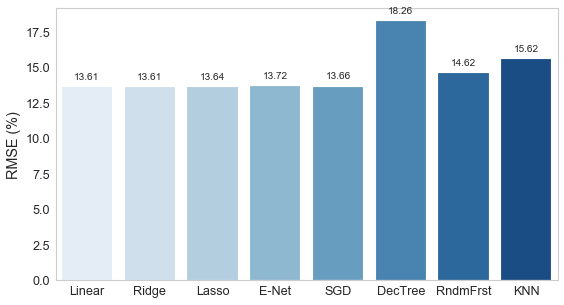

In [37]:
fig, ax = plt.subplots()
fig.set_size_inches(9,5)
splot = sns.barplot(x = regressors, y = rmse, ax = ax, palette = 'Blues')
#sns.set_style("whitegrid", {'axes.grid' : False})
plt.ylabel('RMSE (%)')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
#plt.show()

In [67]:
predictions = {'Linear': pred_lm_all, 'Ridge': pred_ridge_all, 'Lasso': pred_lasso_all,
               'ElaNet': pred_enet, 'SGD': pred_sgd, 'DTr': pred_dtree, 'RF': pred_rf,
               'KNN': pred_knn}
df_predictions = pd.DataFrame(data = predictions) 
df_predictions.corr()

,Linear,Ridge,Lasso,ElaNet,SGD,DTr,RF,KNN
Linear,1.000000,0.999988,0.999768,0.999372,0.999817,0.940926,0.980166,0.963959
Ridge,0.999988,1.000000,0.999816,0.999519,0.999830,0.940705,0.980126,0.964376
Lasso,0.999768,0.999816,1.000000,0.999659,0.999613,0.940989,0.980540,0.964392
ElaNet,0.999372,0.999519,0.999659,1.000000,0.999256,0.939788,0.980019,0.965968
SGD,0.999817,0.999830,0.999613,0.999256,1.000000,0.940400,0.979742,0.964236
DTr,0.940926,0.940705,0.940989,0.939788,0.940400,1.000000,0.968598,0.920521
RF,0.980166,0.980126,0.980540,0.980019,0.979742,0.968598,1.000000,0.961129
KNN,0.963959,0.964376,0.964392,0.965968,0.964236,0.920521,0.961129,1.000000
